In [2]:
import gzip
from collections import *
import os
import csv
import json
import networkx as nx
import pandas as pd
import glob
import seaborn as sns
from matplotlib import pyplot as plt
from collections import Counter,defaultdict


In [74]:
def create_country_and_language_dicts(path_to_dataframes,lang_pairs):
    user_to_country = {}
    user_to_language = {}
    filenames = []
    for lang_pair in lang_pairs:
        filename = os.path.join(path_to_dataframes,f'{lang_pair[0]}_{lang_pair[1]}.tsv')
        df = pd.read_csv(filename,sep='\t',header=None,dtype=str)
        df.columns = ['user_id','lang','bilinguality','country','betw','num_tweets','followers',
                      'following','hashtag_count','url_count','degree']
        for index, row in df.iterrows():
            uid = str(row['user_id'])
            user_to_country[uid] = row['country']
            if row['lang'] == 'BI':
                user_to_language[uid] = f'{lang_pair[0]}_{lang_pair[1]}'
            else:
                user_to_language[uid] = row['lang']
    return user_to_country,user_to_language

In [75]:
dataframe_path = '/shared/0/projects/cross-lingual-exchange/data/dataframes'
lang_pairs = [('de','tr'),('de','pl'),('es','pt')]
user_to_country, user_to_language = create_country_and_language_dicts(dataframe_path,lang_pairs)

In [76]:
data_path = '/shared/2/projects/cross-lingual-exchange/data/'
if not os.path.exists(data_path):
    os.mkdir(data_path)
with open(os.path.join(data_path,'users_countries.json'),'w') as f:
    json.dump(user_to_country,f)
with open(os.path.join(data_path,'users_languages.json'),'w') as f2:
    json.dump(user_to_language,f2)

In [8]:
data_path = '/shared/2/projects/cross-lingual-exchange/data/'
with open(os.path.join(data_path,'users_countries.json'),'r') as f:
    user_to_country = json.load(f)
with open(os.path.join(data_path,'users_languages.json'),'r') as f2:
    user_to_language = json.load(f2)

In [79]:
def create_graph(data_path,user_to_country,user_to_language,country_pair,country_names,language_names):
    filename = os.path.join(data_path,f'{country_pair[0]}_{country_pair[1]}.tsv')
    G = nx.Graph() 
    with open(filename,'r') as f:
        for line in f:
            uid1 = line.split(' ')[0].strip()
            uid2 = line.split(' ')[1].strip()
            # maybe filter only to the ones with attached country and lang
            if (uid1 in user_to_country) and (user_to_country[uid1] in country_names) and (user_to_language[uid1] in language_names):
                if (uid2 in user_to_country) and (user_to_country[uid2] in country_names) and (user_to_language[uid2] in language_names):
                    G.add_node(uid1,country=user_to_country[uid1],language=user_to_language[uid1])
                    G.add_node(uid2,country=user_to_country[uid2],language=user_to_language[uid2])
                    G.add_edge(uid1,uid2)
    return G
        

In [80]:
network_subsets_path = '/shared/0/projects/cross-lingual-exchange/data/network_subsets/'
G_de_pl = create_graph(network_subsets_path,user_to_country,user_to_language,
                       country_pair=('DE','PL'),country_names=('Germany','Poland'), language_names = ('de','pl','de_pl'))


In [120]:
G_de_tr = create_graph(network_subsets_path,user_to_country,user_to_language,
                       country_pair=('DE','TR'),
                       country_names=('Germany','Turkey'), 
                       language_names = ('de','tr','de_tr'))


In [121]:
G_es_pt = create_graph(network_subsets_path,user_to_country,user_to_language,
                       country_pair=('ES','PT'),
                       country_names=('Spain','Portugal'), 
                       language_names = ('es','pt','es_pt'))

In [123]:
Graphs = {}
Graphs['de_pl'] = G_de_pl
Graphs['de_tr'] = G_de_tr
Graphs['es_pt'] = G_es_pt

In [125]:
network_stats = defaultdict(lambda: defaultdict(int))

In [131]:
# Basic calculations and components
for pair in Graphs.keys():
    G = Graphs[pair]
    network_stats[pair]['num_nodes'] = G.number_of_nodes()
    network_stats[pair]['num_edges'] = G.number_of_edges()
    network_stats[pair]['num_components'] = nx.number_connected_components(G)
    [gcc,second_largest] = sorted(nx.connected_components(G), key=len, reverse=True)[:2]
    network_stats[pair]['gcc_size'] = len(gcc)
    network_stats[pair]['second_component_size'] = len(second_largest)
    network_stats[pair]['gcc_fraction'] = len(gcc) / G.number_of_nodes()

In [134]:
# Assortativity measures 
for pair in Graphs.keys():
    G = Graphs[pair]
    network_stats[pair]['degree_assortativity'] = nx.degree_assortativity_coefficient(G)
    network_stats[pair]['country_assortativity'] = nx.attribute_assortativity_coefficient(G,'country')
    network_stats[pair]['language_assortativity'] = nx.attribute_assortativity_coefficient(G,'language') 
    network_stats[pair]['country_mixing'] = nx.attribute_mixing_dict(G,'country',normalized=True)
    network_stats[pair]['language_mixing'] = nx.attribute_mixing_dict(G,'language',normalized=True)

    

In [136]:
data_path = '/shared/2/projects/cross-lingual-exchange/data/'
with open(os.path.join(data_path,'network_stats_02-10-21.json'),'w') as f:
    json.dump(network_stats,f)

In [142]:
network_stats


defaultdict(<function __main__.<lambda>()>,
            {'de_pl': defaultdict(int,
                         {'num_nodes': 133873,
                          'num_edges': 1589441,
                          'num_components': 329,
                          'gcc_size': 133126,
                          'second_component_size': 8,
                          'gcc_fraction': 0.9944200847071478,
                          'degree_assortativity': 0.11017823588661176,
                          'country_assortativity': 0.9931833273503237,
                          'language_assortativity': 0.8153605649611215,
                          'country_mixing': {'Poland': {'Poland': 0.852548789165499,
                            'Germany': 0.0008528155496177587},
                           'Germany': {'Germany': 0.14574557973526542,
                            'Poland': 0.0008528155496177587}},
                          'language_mixing': {'pl': {'pl': 0.8054850730539856,
                            'de_pl':

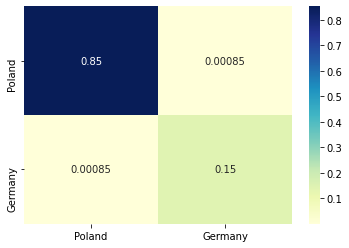

In [107]:
sns.heatmap(pd.DataFrame(mat_de_pl_country),annot=True,cmap="YlGnBu")

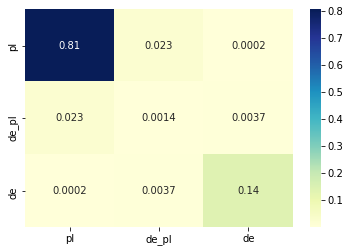

In [108]:
mat_de_pl_country = nx.attribute_mixing_dict(G_de_pl,'language',normalized=True)
sns.heatmap(pd.DataFrame(mat_de_pl_country),annot=True,cmap="YlGnBu")

In [233]:
for pair in Graphs.keys():
    G = Graphs[pair]
    network_stats[pair]['degree_list'] = [d for n, d in G.degree()]
    network_stats[pair]['eigenvector_centrality'] = nx.eigenvector_centrality(G)
    #network_stats[pair]['closeness_centrality'] = nx.closeness_centrality(G)
    #network_stats[pair]['average_clustering'] = nx.average_clustering(G)
    #network_stats[pair]['transitivity'] = nx.transitivity(G)

In [ ]:
data_path = '/shared/2/projects/cross-lingual-exchange/data/'
with open(os.path.join(data_path,'network_stats_02-11-21.json'),'w') as f:
    json.dump(network_stats,f)

Text(0.5, 0, 'degree (log scale)')

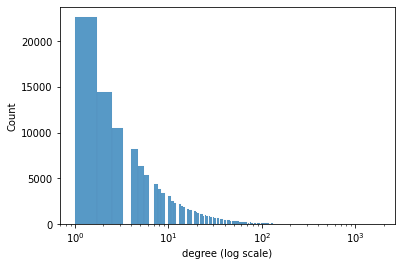

In [117]:
sns.histplot(degs)
plt.xscale('log')
plt.xlabel('degree (log scale)')

#plt.yscale('log')

In [62]:
centrality = nx.eigenvector_centrality(g)

with open('users_with_eigen_centrality.tsv', 'w+') as tsvfile:
    writer = csv.writer(tsvfile, delimiter='\t')
    for node, eigen_centr in centrality.items():
        writer.writerow([node, eigen_centr])

In [63]:
pr = nx.pagerank(g)

with open('users_with_page_rank.tsv', 'w+') as tsvfile:
    writer = csv.writer(tsvfile, delimiter='\t')
    for node, page_rank in pr.items():
        writer.writerow([node, page_rank])

In [64]:
with open('/shared/1/projects/cross-lingual-exchange/data/temp/relevant_users_with_lang_ukde.json', 'r') as f:
    users = json.load(f)
    
    for node in pr.keys():
        if node in users:
            users[node]['page_rank'] = pr[node]
            users[node]['eigen_cent'] = centrality[node]
    
with open('/shared/1/projects/cross-lingual-exchange/data/temp/relevant_users_with_centr.json', 'w+') as f:
    f.write(json.dumps(users, indent = 4))
        

In [140]:
nx.periphery(gcc)

AttributeError: 'set' object has no attribute 'order'

In [139]:
gcc

{'49318960',
 '248733528',
 '92655827',
 '74849350',
 '118339555',
 '2731061585',
 '1529019590',
 '423582624',
 '820395817',
 '424252629',
 '1901238596',
 '392993471',
 '1305104893',
 '323307609',
 '10598672',
 '412205491',
 '1187644153',
 '483209101',
 '468734081',
 '317731667',
 '377279249',
 '258833617',
 '872251165',
 '2837683451',
 '409929099',
 '470224955',
 '307373413',
 '298030771',
 '368400174',
 '1282637449',
 '269025983',
 '276229154',
 '1911395425',
 '255647503',
 '375146528',
 '343274186',
 '186536088',
 '516868879',
 '488802076',
 '766452169',
 '433679956',
 '971770082',
 '253488866',
 '312547855',
 '591994945',
 '1249758842',
 '383843246',
 '352411063',
 '188842730',
 '97735723',
 '2510568899',
 '391619421',
 '619245261',
 '2282539469',
 '2888043311',
 '571826365',
 '2305794394',
 '243600406',
 '1498187473',
 '384923245',
 '457733',
 '405471654',
 '419371745',
 '513753370',
 '2360095171',
 '124600906',
 '1219869458',
 '2354498269',
 '247746873',
 '208181712',
 '227910606

In [144]:
Graphs

{'de_pl': <networkx.classes.graph.Graph at 0x7efb3e134290>,
 'de_tr': <networkx.classes.graph.Graph at 0x7efb4248b910>,
 'es_pt': <networkx.classes.graph.Graph at 0x7efb08bc1f90>}

In [146]:
network_stats['de_pl'].keys()


dict_keys(['num_nodes', 'num_edges', 'num_components', 'gcc_size', 'second_component_size', 'gcc_fraction', 'degree_assortativity', 'country_assortativity', 'language_assortativity', 'country_mixing', 'language_mixing', 'degree_list', 'eigenvector_centrality'])

In [155]:
network_nums = defaultdict(lambda: defaultdict(int))

In [156]:
for pair in Graphs:
    for stat in ['num_nodes', 'num_edges', 'num_components', 
                 'gcc_size', 'second_component_size','gcc_fraction', 
                 'degree_assortativity','country_assortativity', 'language_assortativity']:
        network_nums[stat][pair] = network_stats[pair][stat]
    

In [163]:
df = pd.DataFrame(network_nums)

In [164]:
df = df.reset_index()
df['index']
df = df.rename(columns={"index": "country_pair"})

In [165]:
df

,country_pair,num_nodes,num_edges,num_components,gcc_size,second_component_size,gcc_fraction,degree_assortativity,country_assortativity,language_assortativity
0,de_pl,133873,1589441,329,133126,8,0.994420,0.110178,0.993183,0.815361
1,de_tr,601101,1570808,9471,576820,158,0.959606,0.099390,0.987943,0.824009
2,es_pt,497418,1832243,8607,478036,26,0.961035,0.240686,0.973250,0.179768


In [201]:
def plot_network_stats(stat,df,rounding='.0f'):
    plots = sns.barplot(x='country_pair',y=stat,data=df,order=['de_pl','de_tr','es_pt'])
    for bar in plots.patches:  
        plots.annotate(format(bar.get_height(),rounding ),  
                       (bar.get_x() + bar.get_width() / 2,  
                        bar.get_height()), ha='center', va='center', 
                       size=10, xytext=(0, 5), 
                       textcoords='offset points') 
    sns.despine()
    plt.title(f'{stat} by country pair')

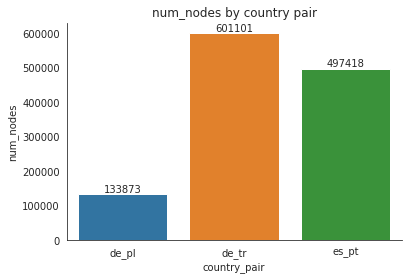

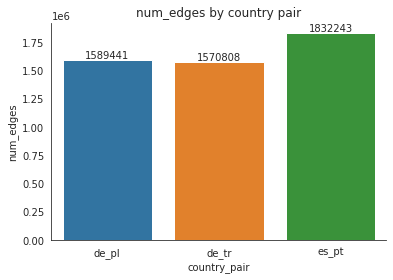

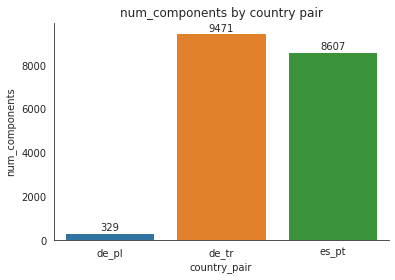

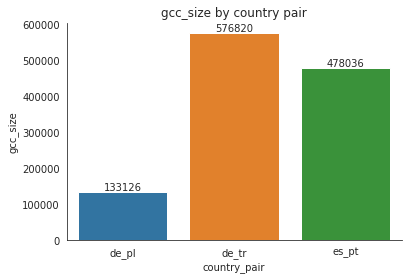

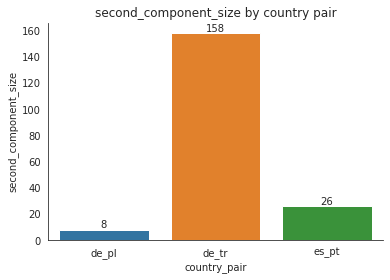

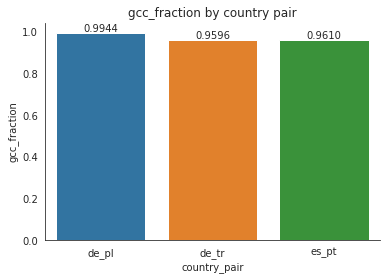

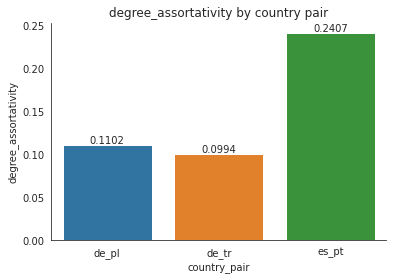

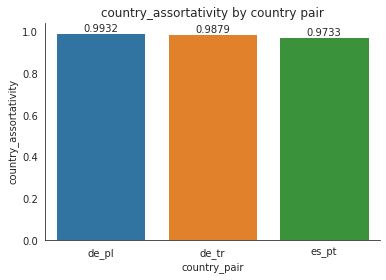

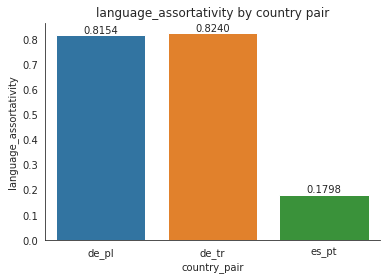

In [203]:
for stat in df.columns[1:]:
    rounding = '.0f'
    if(sum(df[stat]) < 5):
        rounding = '.4f'
    plot_network_stats(stat,df,rounding=rounding)
    plt.show()

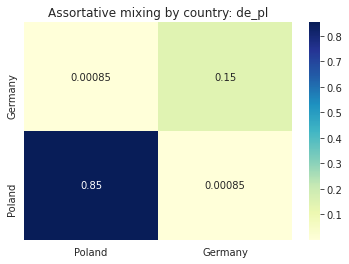

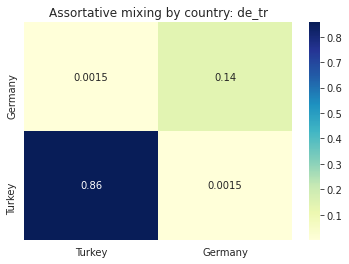

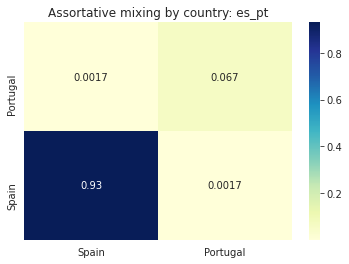

In [254]:
for country_pair in network_stats:
    mat = pd.DataFrame(network_stats[country_pair]['country_mixing'])
    mat.sort_index(ascending=True, inplace=True)
    sns.heatmap(mat,annot=True,cmap="YlGnBu")
    plt.title(f"Assortative mixing by country: {country_pair}")
    plt.show()

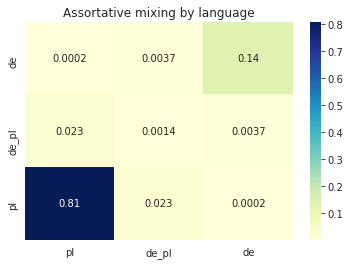

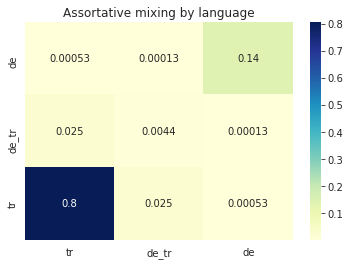

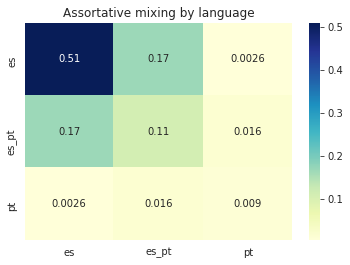

In [216]:
for country_pair in network_stats:
    mat = pd.DataFrame(network_stats[country_pair]['language_mixing'])
    mat.sort_index(ascending=True, inplace=True)
    sns.heatmap(mat,annot=True,cmap="YlGnBu")
    plt.title("Assortative mixing by language")
    plt.show()

In [212]:
sns.histplot(degs)
plt.xscale('log')
plt.xlabel('degree (log scale)')
sns.displot(penguins, x="flipper_length_mm", hue="species", kind="kde")

#plt.yscale('log')

,es,es_pt,pt
es_pt,0.167221,0.111201,0.015535
es,0.509174,0.167221,0.002564
pt,0.002564,0.015535,0.008986


In [235]:
df_degree = defaultdict(lambda: defaultdict(int))
for country_pair in network_stats:
    df_degree[country_pair] = network_stats[country_pair]['degree_list']

In [245]:
df1 = pd.DataFrame()
df1.loc[:,'de_tr'] = pd.Series(df_degree['de_tr'])
df1.loc[:,'es_pt'] = pd.Series(df_degree['es_pt'])
df1.loc[:,'de_pl'] = pd.Series(df_degree['de_pl'])

In [246]:
df1
sns.displot(df1, x="flipper_length_mm", hue="species", kind="kde")

,de_tr,es_pt,de_pl
0,5,1.0,47.0
1,7,14.0,63.0
2,6,13.0,95.0
3,4,60.0,1.0
4,5,13.0,111.0
...,...,...,...
601096,1,NaN,NaN
601097,2,NaN,NaN
601098,1,NaN,NaN
601099,1,NaN,NaN


In [249]:
df1 = pd.melt(df1)
df1.columns = ['country_pair','degree']

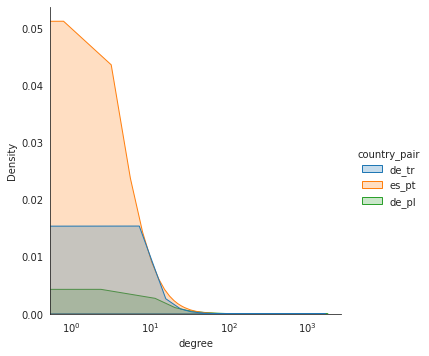

In [253]:
sns.displot(df1, x="degree",hue="country_pair",kind='kde',fill=True)
plt.xscale('log')

In [255]:
df1

,country_pair,degree
0,de_tr,5.0
1,de_tr,7.0
2,de_tr,6.0
3,de_tr,4.0
4,de_tr,5.0
...,...,...
1803298,de_pl,NaN
1803299,de_pl,NaN
1803300,de_pl,NaN
1803301,de_pl,NaN


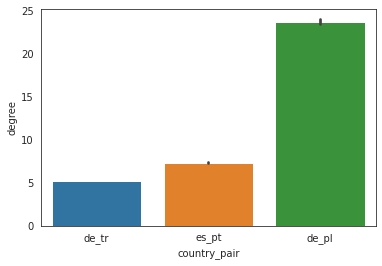

In [256]:
sns.barplot(x='country_pair',y='degree',data=df1)

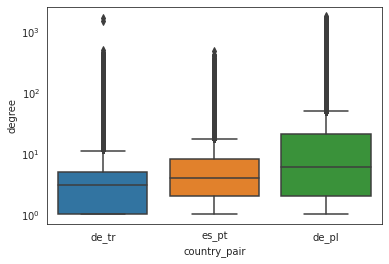

In [258]:
sns.boxplot(x='country_pair',y='degree',data=df1)
plt.yscale('log')

In [1]:
G_de_pl

NameError: name 'G_de_pl' is not defined

In [6]:
def create_graph(data_path,country_pair):
    filename = os.path.join(data_path,f'{country_pair[0]}_{country_pair[1]}.tsv')
    G = nx.Graph() 
    with open(filename,'r') as f:
        for line in f:
            uid1 = line.split(' ')[0].strip()
            uid2 = line.split(' ')[1].strip()
            G.add_edge(uid1,uid2)
    return G

In [7]:
network_subsets_path = '/shared/0/projects/cross-lingual-exchange/data/network_subsets/'

In [8]:
G_de_pl = create_graph(network_subsets_path,('DE',"PL"))
